In [66]:
import os
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
import cmath

abspath = os.getcwd()
i = ["train-housing","trainR-housing","test-housing","testR-housing","train-crime","trainR-crime","test-crime","testR-crime","testR-f3","test-f3","testR-f5","test-f5","trainR-f3","train-f3","trainR-f5","train-f5"]
csv_dict = {}
for j in range(len(i)):
    relative = '\\pp2data\\'+i[j]+'.csv'
    fullpath = abspath+relative
    with open(fullpath) as csv_file:
        filer = csv.reader(csv_file,quoting=csv.QUOTE_NONNUMERIC)
        csv_dict[i[j]] = [line for line in filer]

#pi_data and res_data should be in np.array format

def regularized_model_mle(lambda_val,pi_data,res_data):
    #pi_data - given data matrix, res_data - shared target values of each data of data matrix.
    #taking transpose of data
    pi_transpose = pi_data.transpose()
    identity_mat = np.identity(len(pi_transpose))
    #after identity matrix of length equal to number of features created, multiplied by lambda value
    lambda_mat = np.dot(lambda_val,identity_mat)
    weight_1 = np.dot(pi_transpose,pi_data)
    # "λI + Φ(transpose)*Φ" will be calculated after the below step
    weight_1 = lambda_mat+weight_1
    #taking inverse of the above value
    inv_weight_1 = np.linalg.inv(weight_1)
    #"Φ(transpose)t" is calculated separately
    weight_2 = np.dot(pi_transpose,res_data)
    #finally multiplied both of values calculated separately to determine the final weight matrix.
    weight_fin = np.dot(inv_weight_1,weight_2)
    return weight_fin

#xdata and respdata should be in np.array format

def bayesian_mn_det(alpha,beta,xdata,respdata):
    #xdata - given data matrix, respdata - shared target values of each data of data matrix.
    #Taking transpose of shared data
    x_data_transpose = xdata.transpose()
    #Identity matrix size is dependent on the number of features. since length of transpose matrix will share the number of 
    #  features it is used to determine size.
    identity_mat = np.identity(len(x_data_transpose))
    #after identity matrix of length equal to number of features created, multiplied by alpha value (alpha*I) to determine 
    #  part 1 of sn-1 determination equation
    sn_inv_1 = np.dot(alpha,identity_mat)
    #second part of (sn)-1 is beta*Φ(transpose)*Φ so that is calculated below
    sn_inv_2 = np.dot(x_data_transpose,xdata)
    sn_inv_2 = np.dot(beta,sn_inv_2)
    #finally (sn)-1 = alpha*I + beta*Φ(transpose)*Φ is calculated by adding the part 1 and part 2
    sn_inv = sn_inv_1+sn_inv_2
    
    #Taking inverse of Sn-1 to determine Sn
    sn = np.linalg.inv(sn_inv)
    #to determine Mn = beta*Sn*Φ(transpose)*t, first beta*Sn is determined below.
    mn_1 = np.dot(beta,sn)
    #then Φ(transpose)*t is determined
    mn_2 = np.dot(x_data_transpose,respdata)
    #finally Mn is determined by taking product of those two above determined values.
    mn = np.dot(mn_1,mn_2)
    
    return (mn,sn_inv)

def bayesian_model_Selection(data_model,resp_model):
    #data_model - given data matrix, resp_model - shared target values of each data of data matrix.
    #Initializing the values of alpha and beta
    alpha_det = 9
    beta_det = 9
    count = 0
    alpha_int,beta_int = 0,0
    #Taking the transpose of the given data matrix
    data_model_transpose = data_model.transpose()
    #calculating Φ(transpose)*Φ
    dot_prod_data = np.dot(data_model_transpose,data_model)
    #after alpha and beta initialized the loop is executed until the difference between the alpha determined very recently 
    #  and the alpha determined just before that is less than 10^-5. similarly for beta also.
    abs_alpha = abs(alpha_int-alpha_det)
    abs_beta = abs(beta_int-beta_det)
    #checking whether the above explained difference is present, until that this loop will execute.
    while((abs_alpha > (10**-5)) & (abs_beta > (10**-5))):
        #each time assigned with most recently calculated alpha and beta to use for calculating the next alpha and beta.
        alpha_int = alpha_det
        beta_int = beta_det
        #with the most recent alpha, Mn and Sn-1 is determined using the previously defined function.
        mn_det,sn_inv_det = bayesian_mn_det(alpha_int,beta_int,data_model,resp_model)
        #beta*Φ(transpose)*Φ is calculated to determine the eigen values of that final product matrix.
        beta_data = np.dot(beta_int,dot_prod_data)
        lambda_eig,eig_v = np.linalg.eig(beta_data)
        #gamma is determine from that eigen values and existing alpha value using the formula,γ = summation over i(λi/(α + λi)).
        gamma = (lambda_eig/(alpha_int+lambda_eig)).sum()
        #Mn(transpose)*Mn is determined
        mn_prod = np.dot((mn_det.transpose()),mn_det)
        #finally alpha is determined using formula, α = γ/(Mn(transpose)*Mn)
        alpha_det_mat = gamma/mn_prod
        #since the determine alpha will be of form matrix with 0,0 for example, the form will be like, [[1.2]]
        #  to extract value alone from that below line is added.
        alpha_det = alpha_det_mat[0][0]
        #with Φ matrix and Mn determined above, the calculated target values are determined.
        beta_det1 = np.dot(data_model,mn_det)
        #finding the difference between the calculated target values and the actual target values of each data line.
        beta_det_mat = resp_model-beta_det1
        #finding the square of the difference of above calculated value.
        beta_det_mat = np.square(beta_det_mat)
        #as per the equation 3.95 of bishop book inverse of beta is summation of the above calculated matrix values/(N − γ). 
        #  So, to determine Beta, we have done (N − γ)/(summation of the above calculated matrix values).
        beta_det = (len(data_model)-gamma)/(beta_det_mat.sum())
        #Then determining the difference between newly calculated values and the values before that to check the while loop condition.
        abs_alpha = abs(alpha_int-alpha_det)
        abs_beta = abs(beta_int-beta_det)
    # final weight matrix called as Mn values is determined with the latest alpha and beta values.
    final_mn,final_sn_inv = bayesian_mn_det(alpha_det,beta_det,data_model,resp_model)
    return final_mn,beta_det,alpha_det    

def Mean_squared_error_fn(data,weight,response):
    #taking the transpose of data matrix and multiplying with weight matrix such that 
    #  each feature of eery data is multiplied with corresponding weight value 
    #  and then caculated the target values for each data line by taking sum of every feature value.
    data_trans = data.transpose()
    calc_val = np.dot(data,weight)
    #Finding the difference between calculated and the actual response values.
    val_diff2 = calc_val-response
    #finding the square of that difference of each data line.
    val_diff2 = np.square(val_diff2)
    #finally taking sum of that squared values and diving it by number of data line to determine the MSE.
    final_sum = (val_diff2.sum())/len(response)
    return(final_sum)
        
def main_function_1(train,trainR,test,testR):
    mse_reg_fn = {}
    #given data matrix for training the model
    train = np.array(train)
    #given target values for each data lines.
    trainR = np.array(trainR)
    test = np.array(test)
    testR = np.array(testR)
    train_set = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    bms_fn = {}
    mse_map_param = []
    lambda_set = [0.0,1.0,33.0,100.0,1000.0]
    #for each of the above lambda values, mse is calulcated for various training size and stored in a dictionary.
    for j in range(len(lambda_set)):
        mse_reg = {}
        for i in range(len(train_set)):
            weight1 = regularized_model_mle(lambda_set[j],train[0:(int(math.ceil(len(train)*train_set[i]))),0:(len(train[1]))],trainR[0:(int(math.ceil(len(trainR)*train_set[i]))),0:(len(trainR[1]))])
            mse_reg[int(len(train)*(train_set[i]))] = Mean_squared_error_fn(test,weight1,testR)
        mse_reg_fn[lambda_set[j]] = mse_reg
    #for each of the training size, alpha beta is determined and then finally mse is determined and stored as part of dictioanary.
    for i in train_set:
        weight2,beta_fn,alpha_fn = bayesian_model_Selection(train[0:(int(math.ceil(len(train)*i))),0:(len(train[1]))],trainR[0:(int(math.ceil(len(trainR)*i))),0:(len(trainR[1]))])
        mse_bsm = Mean_squared_error_fn(test,weight2,testR)
        bms_fn[int(len(train)*i)] = mse_bsm
        list_parm = []
        list_parm.append(int(len(train)*i))
        list_parm.append(alpha_fn)
        list_parm.append(beta_fn)
        lambda_fn = alpha_fn/beta_fn
        list_parm.append(lambda_fn)
        mse_map_param.append(list_parm)
    return(mse_reg_fn,bms_fn,mse_map_param)
#calculating the mle, map and mse for different training size
# also calculating mle and mse for different lambda value of housing and crime data.
mse_mle1,mse_map1,mse_map_param1 = main_function_1(csv_dict['train-housing'],csv_dict['trainR-housing'],csv_dict['test-housing'],csv_dict['testR-housing'])
mse_mle2,mse_map2,mse_map_param2 = main_function_1(csv_dict['train-crime'],csv_dict['trainR-crime'],csv_dict['test-crime'],csv_dict['testR-crime'])

#Displaying the caculated alpha, beta and eff lambda of the bayesian model for various training size,
#  by using formula lambda = alpha/beta
print("1st question Part 1")
print("-----")
print("Housing data")
print("Bayesian model selection parameters value for various train size")
print('train size  ','alpha       ','beta        ','eff-lambda')
for i in range(len(mse_map_param1)):
    train_size,alpha,beta,lambda_fn = mse_map_param1[i]
    print(train_size,"        ",round(alpha.real,2),"      ",round(beta.real,2),"      ",round(lambda_fn.real,2))
print("\n\nCrime data")
print("Bayesian model selection parameters value for various train size")
print('train size  ','alpha       ','beta        ','eff-lambda')
for i in range(len(mse_map_param2)):
    train_size,alpha,beta,lambda_fn = mse_map_param2[i]
    print(train_size,"        ",round(alpha,2),"      ",round(beta,2),"      ",round(lambda_fn,2))
print("-----")


1st question Part 1
-----
Housing data
Bayesian model selection parameters value for various train size
train size   alpha        beta         eff-lambda
10          19.68        49.64        0.4
20          16.99        3.62        4.69
30          17.1        4.3        3.97
40          18.41        5.13        3.59
51          17.81        4.41        4.04
61          19.53        4.79        4.08
71          18.62        4.47        4.17
81          18.93        4.59        4.13
91          16.98        4.17        4.07
102          20.41        4.04        5.05


Crime data
Bayesian model selection parameters value for various train size
train size   alpha        beta         eff-lambda
169          188.66        3.08        61.29
339          284.72        2.96        96.05
508          267.21        2.85        93.7
678          280.44        2.85        98.41
847          282.76        2.91        97.01
1017          263.47        2.96        88.94
1186          252.36        3


Housing data
1st question part 2 - MSE for non regularization MLE and bayesian model selection


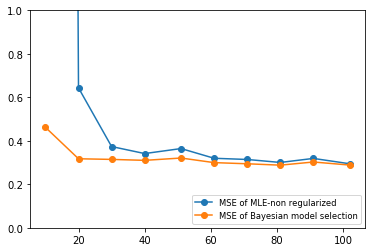

Housing data
1st question part 3 - MSE for regularization with values, 1,33,100,1000 and bayesian model selection


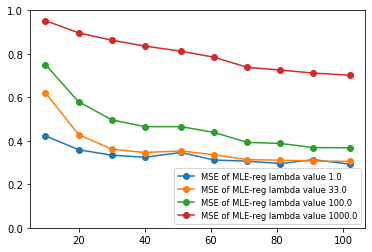

Housing data
MSE plot for all the calculated lambda values of MLE and also for MAP of bayesian model selection


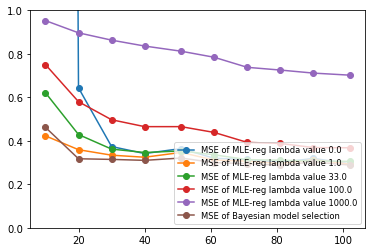

crime data
1st question part 2 - MSE for non regularization MLE and bayesian model selection


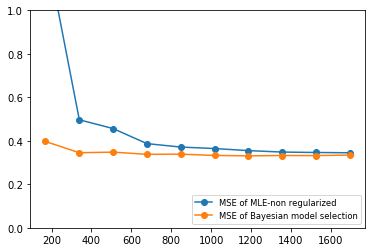

crime data
1st question part 3 - MSE for regularization with values, 1,33,100,1000 and bayesian model selection


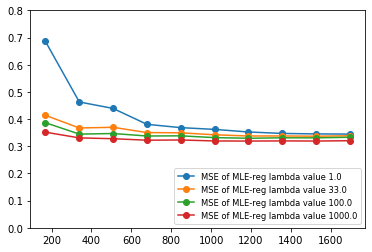

crime data
MSE plot for all the calculated lambda values of MLE and also for MAP of bayesian model selection


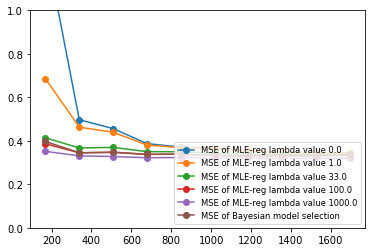

In [67]:
print("\nHousing data")
#displaying the non reg model and bayesian model mse values for various training size.
print("1st question part 2 - MSE for non regularization MLE and bayesian model selection")
myList1 = mse_mle1[0].items()
x1, y1 = zip(*myList1)
plt.plot(x1, y1,label="MSE of MLE-non regularized",marker='o')
myList1 = mse_map1.items()
x1, y1 = zip(*myList1)
plt.plot(x1, y1,label="MSE of Bayesian model selection",marker='o')
plt.ylim([0,1])
plt.legend(loc = 4,fontsize = 'small')
plt.show()

#displaying the mse for various lambda values with corresponding trainig size data.
print("Housing data")
print("1st question part 3 - MSE for regularization with values, 1,33,100,1000 and bayesian model selection")
for i in mse_mle1.keys():
    #below condition to avoid the displaying of mse values corresponding to lambda equal to 0.
    if (i != 0):
        myList1 = mse_mle1[i].items()
        x1, y1 = zip(*myList1)
        plt.plot(x1, y1,label="MSE of MLE-reg lambda value "+str(i),marker='o')
plt.ylim([0,1])
plt.legend(loc = 4,fontsize = 'small')
plt.show()

#displaying mse of all models.
print("Housing data")
print("MSE plot for all the calculated lambda values of MLE and also for MAP of bayesian model selection")
for i in mse_mle1.keys():
    #below condition to avoid the displaying of mse values corresponding to lambda equal to 0.
    myList1 = mse_mle1[i].items()
    x1, y1 = zip(*myList1)
    plt.plot(x1, y1,label="MSE of MLE-reg lambda value "+str(i),marker='o')
myList1 = mse_map1.items()
x1, y1 = zip(*myList1)
plt.plot(x1, y1,label="MSE of Bayesian model selection",marker='o')
plt.ylim([0,1])
plt.legend(loc = 4,fontsize = 'small')
plt.show()

print("crime data")
#displaying the non reg model and bayesian model mse values for various training size.
print("1st question part 2 - MSE for non regularization MLE and bayesian model selection")
myList1 = mse_mle2[0].items()
x1, y1 = zip(*myList1)
plt.plot(x1, y1,label="MSE of MLE-non regularized",marker='o')
myList1 = mse_map2.items()
x1, y1 = zip(*myList1)
plt.plot(x1, y1,label="MSE of Bayesian model selection",marker='o')
plt.ylim([0,1])
plt.legend(loc = 4,fontsize = 'small')
plt.show()

#displaying the mse for various lambda values with corresponding trainig size data.
print("crime data")
print("1st question part 3 - MSE for regularization with values, 1,33,100,1000 and bayesian model selection")
for i in mse_mle2.keys():
    if (i != 0):
        myList1 = mse_mle2[i].items()
        x1, y1 = zip(*myList1)
        plt.plot(x1, y1,label="MSE of MLE-reg lambda value "+str(i),marker='o')

plt.ylim([0,0.8])
plt.legend(loc = 4,fontsize = 'small')
plt.show()

#displaying mse of all models.
print("crime data")
print("MSE plot for all the calculated lambda values of MLE and also for MAP of bayesian model selection")
for i in mse_mle2.keys():
    myList1 = mse_mle2[i].items()
    x1, y1 = zip(*myList1)
    plt.plot(x1, y1,label="MSE of MLE-reg lambda value "+str(i),marker='o')
myList1 = mse_map2.items()
x1, y1 = zip(*myList1)
plt.plot(x1, y1,label="MSE of Bayesian model selection",marker='o')
plt.ylim([0,1])
plt.legend(loc = 4,fontsize = 'small')
plt.show()

In [70]:
import math
# from the given data, Pi matrix or the final data matrix is formed for various dimensional values.
def data_file_gn(dimen,data):
    final_data = []
    for i in range(len(data)):
        val = []
        for j in range(0,dimen+1):
            val.append((data[i][0])**j)
        final_data.append(val)
    final_data = np.array(final_data)
    return final_data

def log_evi(alpha_evi,beta_evi,mn_evi,sninv_evi,data_evi,resp_evi):
#calculating the log evidence based on 3.86 equation of bishop. 
#this equation has five different terms, so calculated those terms separately and then calulcated the final value.
    #total number of data lines.
    N = len(data_evi)
    #total number of features
    M = len(data_evi[0])
    #term1 of the equation calculated.
    T1 = (M/2)*(np.log(alpha_evi))
    #term 2 of the equation calculated.
    T2 = (N/2)*(np.log(beta_evi))
    #determinign the calculated target values and calculating the difference between that and the actual value for each data line.
    data_mn = np.dot(data_evi,mn_evi)
    data_mn = resp_evi-data_mn
    #squaring the difference for each data line and determing the sum of those squared difference.
    data_mn = np.square(data_mn)
    sum_mn = data_mn.sum()
    #term 3 has two parts, 1st part calculated from below.
    T3_1 = ((beta_evi/2)*sum_mn)
    mn_tr = mn_evi.transpose()
    #determingin the Mn(transpose)*Mn values
    mn_mat = np.dot(mn_tr,mn_evi)
    #second part of term 3 is calculated from below.
    T3_2 = np.dot((alpha_evi/2),mn_mat)
    #term 4 of the equation calculated below.
    T4 = 0.5*(np.log(np.linalg.det(sninv_evi)))
    #term 5 of the equation calculated below.
    T5 = (N/2)*np.log(2*(math.pi))
    #final log evidence function is calculated from below.
    evi_fn = T1+T2-T3_1-T3_2-T4-T5
    return evi_fn
def main_function_2(train2,trainR2,test2,testR2):
    d = [i for i in range(1,11)]
    mse_map2 = {}
    mse_mle2 = {}
    log_evi2 = {}
    trainR2 = np.array(trainR2)
    testR2 = np.array(testR2)
    for i in range(len(d)):
        #determining the final data set of training and test data based on the required dimensional value
        fin_train2 = data_file_gn(d[i],train2)
        fin_test2 = data_file_gn(d[i],test2)
        # based on the final data set, weight matrix or the Map value(also called as Mn) is determined.
        weight_map,beta_fn,alpha_fn = bayesian_model_Selection(fin_train2,trainR2)
        #MSE for that corresponding weight matrix, is determined with test data.
        mse_map2[d[i]] = Mean_squared_error_fn(fin_test2,weight_map,testR2)
        lambda_fn = alpha_fn/beta_fn
        #Weight matrix with lambda equal to 0 of the mle model is determined.
        weight_mle = regularized_model_mle(0,fin_train2,trainR2)
        #corresponding MSE is determined.
        mse_mle2[d[i]] = Mean_squared_error_fn(fin_test2,weight_mle,testR2)
        mn_evi,sn_inv_evi = bayesian_mn_det(alpha_fn,beta_fn,fin_train2,trainR2)
        # with determined final alpha, beta values and also with Mn and Sn-1 values log evidence is calculated.
        log_evi_mat = log_evi(alpha_fn,beta_fn,mn_evi,sn_inv_evi,fin_train2,trainR2)
        log_evi2[d[i]] = log_evi_mat[:,0]

    return(mse_mle2,mse_map2,log_evi2)
#MSE for MLE, MAP and LOG EVIDENCE function for the two given data set with different dimensional values is determined
mle_fn_3,map_fn_3,log_evi_fn_3=main_function_2(csv_dict['train-f3'],csv_dict['trainR-f3'],csv_dict['test-f3'],csv_dict['testR-f3'])
mle_fn_5,map_fn_5,log_evi_fn_5=main_function_2(csv_dict['train-f5'],csv_dict['trainR-f5'],csv_dict['test-f5'],csv_dict['testR-f5'])
print("MSE of MLE and Bayesian model for data F3")
print(mle_fn_3)
print(map_fn_3)
print("MSE of MLE and Bayesian model for data F5")
print(mle_fn_5)
print(map_fn_5)


MSE of MLE and Bayesian model for data F3
{1: 39389142.58553825, 2: 39495762.45900569, 3: 148429.3883649426, 4: 179627.46131849606, 5: 186263.56079639218, 6: 211370.6073940488, 7: 211030.05221867646, 8: 219229.879478664, 9: 226345.88116710776, 10: 270774.8068386121}
{1: 39376476.11601517, 2: 39527146.41872832, 3: 96455.98109742106, 4: 154882.81449527247, 5: 157992.413764386, 6: 165209.15501289774, 7: 182897.76545493054, 8: 194734.91580312623, 9: 186392.13599227005, 10: 231746.58034261907}
MSE of MLE and Bayesian model for data F5
{1: 341642661126.0123, 2: 341195638304.2563, 3: 17465602121.93236, 4: 17435655143.623474, 5: 61375.345065543755, 6: 79043.0543017258, 7: 106031.55252956954, 8: 104840.41212287817, 9: 110065.56808059901, 10: 108832.5524214696}
{1: 341402522422.93665, 2: 341325174572.45123, 3: 17502036953.65271, 4: 17478865442.561092, 5: 54311.85449418849, 6: 69754.35175814199, 7: 90768.26886716852, 8: 90681.85947563125, 9: 104393.1057899487, 10: 100850.61705746669}


No handles with labels found to put in legend.


PLOTS for F3 data
MSE of MLE and Bayesian model along with log evidence


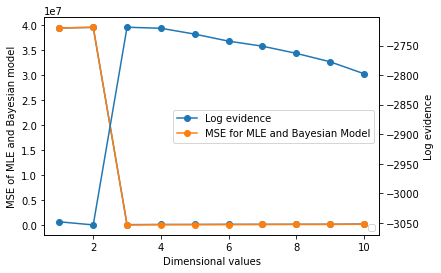

Note: Since MSE of MAP and MLE gave similar values, graph of both gave same plot and got superimposed one over other and shown as orange plot


PLOTS for F5 data
MSE of MLE and Bayesian model along with log evidence


No handles with labels found to put in legend.


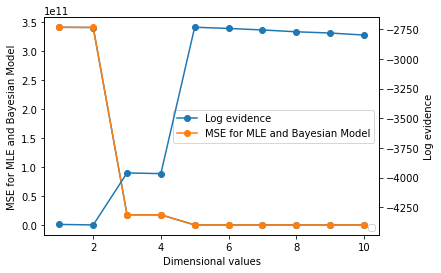

Note: Since MSE of MAP and MLE gave similar values, graph of both gave same plot and got superimposed one over other and shown as orange plot


In [72]:
#ploting the MSE of MLE and MAP models as well as log evidence model for various dimensional values with given data F3.
print("PLOTS for F3 data")
print("MSE of MLE and Bayesian model along with log evidence")

fig, ax1 = plt.subplots()
myList1 = mle_fn_3.items()
x1, y1 = zip(*myList1)
ax1.plot(x1, y1,marker='o')
myList1 = map_fn_3.items()
x1, y1 = zip(*myList1)
ax1.set_ylabel("MSE of MLE and Bayesian model")
ax1.set_xlabel("Dimensional values")
ax1.plot(x1, y1,marker='o')
ax1.legend(labels=["Log evidence","MSE for MLE and Bayesian Model"],loc = 'center right')
ax2=ax1.twinx()
myList1 = log_evi_fn_3.items()
x1, y1 = zip(*myList1)
ax2.set_ylabel("Log evidence")
ax2.plot(x1, y1,marker='o')
plt.legend(loc = 4,fontsize = 'small')
plt.show()
print("Note: Since MSE of MAP and MLE gave similar values, graph of both gave same plot and got superimposed one over other and shown as orange plot")


#ploting the MSE of MLE and MAP models as well as log evidence model for various dimensional values with given data F5.
print("\n\nPLOTS for F5 data")
print("MSE of MLE and Bayesian model along with log evidence")

fig, ax1 = plt.subplots()
myList1 = mle_fn_5.items()
x1, y1 = zip(*myList1)
ax1.set_ylabel("MSE for MLE and Bayesian Model")
ax1.set_xlabel("Dimensional values")
ax1.plot(x1, y1,label = "mle mse",marker='o')
myList1 = map_fn_5.items()
x1, y1 = zip(*myList1)
ax1.plot(x1, y1,marker='o')
ax1.legend(labels=["Log evidence","MSE for MLE and Bayesian Model"],loc = 'center right')
ax2 = ax1.twinx()
myList1 = log_evi_fn_5.items()
x1, y1 = zip(*myList1)
ax2.set_ylabel("Log evidence")
ax2.plot(x1, y1,marker='o')
plt.legend(loc = 4,fontsize = 'small')
plt.show()
print("Note: Since MSE of MAP and MLE gave similar values, graph of both gave same plot and got superimposed one over other and shown as orange plot")